# Appliances with multiple cycles


An example of an appliance with multiple cycle is a fridge. Fridges
usually have different duty cycles, which can be estimated based on seasonal
temperature trends and/or frequency of user interaction (e.g., how often the 
door gets opened).

In this example a fridge with 3 different duty cycles is modelled. The
time windows are defined for 3 different cycles across 3 different season
types:


| season type |               Standard cycle              |  Intermediate cycle |   Intensive cycle   |
|-------------|:-----------------------------------------:|:-------------------:|:-------------------:|
| Hot         | 00:00:00 - 04:59:00 & 20:01:00 - 23:59:00 | 05:00:00 - 07:59:00 | 08:00:00 - 20:00:00 |
| Warm        | 00:00:00 - 04:59:00 & 18:01:00 - 23:59:00 | 05:00:00 - 09:39:00 | 09:40:00 - 18:00:00 |
| Cold        | 00:00:00 - 04:59:00 & 20:01:00 - 23:59:00 | 05:00:00 - 20:00:00 |          -          |

### Creating the user and appliance

In [1]:
# importing functions
from ramp import User, UseCase, get_day_type
import pandas as pd

In [2]:
# creating user
household = User()

In [3]:
# creating the appliance
fridge = household.Appliance(
    name="Fridge",
    number=1,
    power=200,
    num_windows=1,
    func_time=1400,
    time_fraction_random_variability=0,
    func_cycle=30,
    fixed="yes",
    fixed_cycle=3,  # number of cycles
)

In [4]:
# setting the functioning windows
fridge.windows([0, 1440])  # always on during the whole year

### Assigining the specific cycles

In [5]:
# assiging the specific cycles
# first cycle: standard cycle
fridge.specific_cycle_1(
    p_11=200,
    t_11=20,
    p_12=5,
    t_12=10,
)

# second cycle: intermediate cycle
fridge.specific_cycle_2(
    p_21=200,
    t_21=15,
    p_22=5,
    t_22=15,
)

# third cycle: intensive cycle
fridge.specific_cycle_3(
    p_31=200,
    t_31=10,
    p_32=5,
    t_32=20,
)

After defining the cycle power and duration parameters, the time windows of year at which the cycles happens should be specifid by:

In [6]:
# defining cycle behaviour
fridge.cycle_behaviour(
    cw11=[480, 1200], cw21=[300, 479], cw31=[0, 229], cw32=[1201, 1440]
)

### Building the profiles

In [7]:
use_case = UseCase(users=[household])
use_case.peak_time_range = use_case.calc_peak_time_range()

In [8]:
# days to build the profiles
days = [
    "2020-05-16",
    "2020-08-16",
    "2020-12-16",
]

profiles = pd.DataFrame(index=range(0, 1440), columns=days)

for day_idx, day in enumerate(days):
    profile = household.generate_single_load_profile(
        prof_i=day_idx,  # the day to generate the profile
        day_type=get_day_type(day),
    )

    profiles[day] = profile

print(profiles)

The app Fridge has duty cycle option on, however the switch on event fell outside the provided duty cycle windows
The app Fridge has duty cycle option on, however the switch on event fell outside the provided duty cycle windows
      2020-05-16  2020-08-16  2020-12-16
0          0.001       0.001       0.001
1          0.001       0.001       0.001
2          0.001       0.001       0.001
3          0.001       0.001       0.001
4          0.001       0.001       0.001
...          ...         ...         ...
1435       0.001     200.000       0.001
1436       0.001     200.000       0.001
1437       0.001       0.001       0.001
1438       0.001       0.001       0.001
1439       0.001       0.001       0.001

[1440 rows x 3 columns]


<AxesSubplot:>

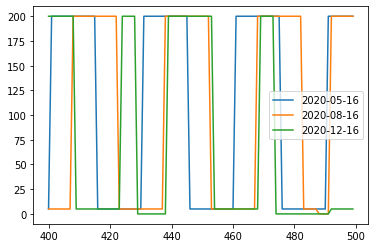

In [9]:
# plotting a part of the days
profiles.iloc[400:500].plot()

## Appliances with continuous duty cycle or productive use

By default, RAMP models duty cycle in contunuous mode. Given time of use window some switch-on events of random duration are generated and filled with duty cycles. If the duration of the switch-on events is longer than one duty cycle, the load profile is filled with repetitions of the duty cycle.

In case of productive uses such as welding, milling or the use of machinery in a carpentry, where appliances are switched on many times within the working hours, switch-on events duration should be limited to the duration of the duty cycle, resulting in one duty cycle per switch-on event.

In order to model an appliance having a productive use duty cycle, set the attribute `continuous_duty_cycle` to `0` as in this example below



You will simulate 1 day(s) from 2024-03-19 00:00:00 until 2024-03-20 00:00:00


<AxesSubplot:>

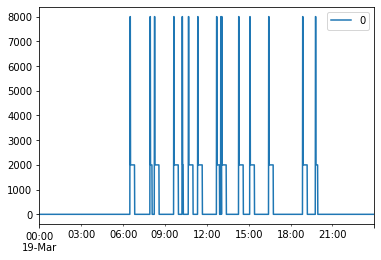

In [10]:
test_user = User(user_name="test_user", num_users=1)

# Create test appliance
test_appliance = test_user.add_appliance(
    name="test_appliance_with_duty_cycles",
    func_time=4 * 60,  # runs for 2 hours per day
    num_windows=1,
    window_1=[6 * 60, 20 * 60],  # usage timeframe from 06:00 to 20:00
    fixed_cycle=1,  # appliance uses duty cycles
    # Duty cycle 1
    p_11=8000,  # power of the first cycle
    t_11=2,  # time needed for the first cycle
    p_12=2000,  # power of the second cycle
    t_12=18,  # time needed for the second cycle
    continuous_duty_cycle=0,  # appliance run the duty cycle once per switch on event
)
# Create and initialize UseCase
uc = UseCase(name="duty_cycle_test", users=[test_user])
uc.initialize(num_days=1)

daily_load_profile = pd.DataFrame(
    uc.generate_daily_load_profiles(),
    index=uc.datetimeindex,
)

daily_load_profile.plot()

In order to illustrate how a continuous cycle woud look like, let's set the `continuous_duty_cycle` back to `1`

<AxesSubplot:>

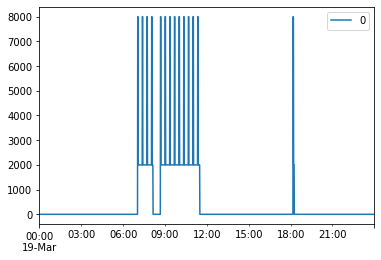

In [11]:
test_appliance.continuous_duty_cycle = 1

daily_load_profile = pd.DataFrame(
    uc.generate_daily_load_profiles(),
    index=uc.datetimeindex,
)

daily_load_profile.plot()

One can see that the switch on events are longer and more than one duty cycle run within the switch on event